<a href="https://colab.research.google.com/github/glima91/mestrado-redes-neurais/blob/main/Perceptron_Multiclasse.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Implemente uma Rede Neural rasa para classificação de uma base multiclasse.

Esta rede deve:

- Aceitar rótulos que podem ser números ou textos;

- Predizer os rótulos originais da base de dados;

- Passar por parâmetro no construtor:

- Função de custo e cálculo do gradiente;

- Taxa de aprendizado;

- Número máximo de iterações;

- Threshold;

- Funcionar para bases binárias.

Teste pelo menos duas funções de custo diferentes em uma base multiclasse e uma base binária.

Plote gráficos com os hiperplanos separadores encontrados pelos algoritmos de treinamento. Se a base escolhida tiver mais do que 2 características, escolha as que você julgar que fornecem a melhor visualização.


In [33]:

# Importação de bibliotecas
from sklearn.base import BaseEstimator, ClassifierMixin
import random
import numpy as np
import matplotlib.pyplot as plt

from abc import ABC, abstractmethod
from scipy.special import expit
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize

In [34]:
# Plot
def plotDataset(X, y):
  plt.xlabel('x1')
  plt.ylabel('x2')

  for k in set(y):
      plt.plot(X[:,0][y==k],
                X[:,1][y==k],
                "o", alpha=0.3)
      
def plotHiperplano(X, y, vetor, intercept=0):
    x0min = min(X[:,0])
    x0max = max(X[:,0])

    xs = np.linspace(x0min, x0max, num=2)
    ys = -(vetor[0]/vetor[1])*xs-intercept/vetor[1]
    plt.title('Hiperplanos Separadores')
    plt.plot(xs, ys)

def plotCost(cost):
  
  x_l = list(range(1, len(cost)+1))

  plt.figure(figsize=(20,5))
  plt.plot(x_l, cost,"-")
  #plt.xticks(x_l)
  plt.title("Perceptron")
  plt.xlabel('Num. da Iteração')
  plt.ylabel('Custo')
  plt.show()

In [35]:
# Cria datasets
def criaDataset(n=1000, n_classes=4):
  X, y = make_blobs(n_samples=n, centers=n_classes, center_box=(0,1.0), cluster_std=0.02)
  return X, y 

def criaDatasetbinario(n=200):
  X = np.random.uniform(size=(n, 2))
  y = np.array(X[:,0] > X[:,1], dtype=int) * 2 - 1
  return X, y

def criaDatasetXor(n=1000):
  X, y = make_blobs(n_samples=n, centers=[[0,0], [1,0],[1,1],[0,1]], cluster_std=0.1)
  y = np.array(y%2, dtype=int)
  return X, y

In [36]:
X, y = criaDataset()
#X, y = criaDatasetbinario()
#X,y = criaDatasetXor()

Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=.9)

In [37]:
ytr

array([2, 3, 0, 0, 0, 0, 2, 1, 0, 0, 0, 3, 2, 0, 0, 3, 3, 3, 0, 1, 1, 1,
       0, 3, 3, 2, 2, 0, 2, 0, 3, 2, 3, 1, 2, 1, 1, 0, 0, 1, 2, 2, 1, 1,
       3, 0, 0, 3, 1, 2, 3, 1, 2, 1, 3, 2, 1, 0, 2, 1, 1, 2, 1, 1, 2, 1,
       1, 0, 1, 0, 0, 2, 2, 1, 3, 0, 1, 0, 3, 1, 0, 0, 3, 3, 3, 3, 2, 3,
       1, 3, 1, 3, 0, 0, 2, 1, 1, 1, 3, 3])

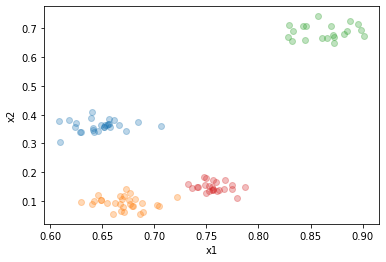

In [38]:
# Plotagem de dois atributos da base de dados
plotDataset(Xtr, ytr)

In [39]:
# Perceptron multiclasse

def sign(a):
  return (a>=0) * 2 - 1

def accuracy(yactual, ypred):
  return sum(yactual == ypred)/len(yactual)

class Perceptron(BaseEstimator, ClassifierMixin):
  def __init__(self,training_algorithm):
    self.w = None
    # funcao de ativação
    self.activation = sign
    # training algorithm
    self.training_algorithm = training_algorithm
    # Erro em cada iteração
    self.cost_batch = []

  # __ e uma convencao pra falar que o metodo e privado
  def __pre_activation(self,X):
    Xb = Perceptron.includebias(X)
    return Xb @ self.w

  @staticmethod
  def includebias(X):
    bias = np.ones((X.shape[0], 1))
    Xb = np.concatenate((bias, X), axis=1)
    return Xb

  def encode_labels(self, y):
    self.labels = list(set(y))
    return label_binarize(y, classes=self.labels) * 2 -1

  def fit(self, X, y):
    yhot = self.encode_labels(y)
    Xb = Perceptron.includebias(X)
    self.w = self.training_algorithm.getW(Xb, yhot)

  def predict(self, X, y=None):
    a =  self.__pre_activation(X)
    
    if self.w.shape[1] == 1:
      idx = np.array(a > 0, dtype=int).reshape((-1,))
    else:
      idx = np.argmax(a, axis=1)
    ypred = np.array([self.labels[i] for i in idx])
    return ypred   

In [40]:
# Classes abstratas
class TrainingAlgorithm(ABC):
  @abstractmethod
  def getW(self,X,y):
    pass

class PseudoInversa(TrainingAlgorithm):
  def getW(self, X,y):
    print(np.linalg.pinv(X) @ y)
    return np.linalg.pinv(X) @ y

# Funcoes de custo
class Custo(ABC):
  @abstractmethod
  def custo(y, ypred):
    pass
  @abstractmethod
  def gradiente(y, ypred):
    pass

class WidrowHoff(Custo):
  @staticmethod
  def custo(y, ypred):
    return np.sum((y - ypred) ** 2)
  @staticmethod
  def gradiente(y, ypred):
    return y- ypred
  
class SmoothedSurrogate(Custo):
  @staticmethod
  def gradiente(y, ypred):
    return y - sign(ypred)

  @staticmethod
  def custo(y, ypred):
    return np.sum(np.maximum(np.zeros(y.shape), -y * ypred))

class LogLikehood(Custo):
  @staticmethod
  def gradiente(y, ypred):
    return y - (expit(ypred)*2 - 1)

  @staticmethod
  def custo(y, ypred):
    return np.sum(np.log(1+np.exp(-y * ypred)))

class HingeLoss(Custo):
  @staticmethod
  def custo(y, ypred):
    return np.sum(np.maximum(np.zeros(y.shape), 1 - y*ypred))
  
  @staticmethod
  def gradiente(y, ypred):
    errosmarginais = (y * ypred) < 1
    ymarginais = np.copy(y)
    ymarginais[~errosmarginais] = 0
    return ymarginais

In [41]:
# Otimização por gradiente descendente
class DescidaGradiente(TrainingAlgorithm):
  def __init__(self, max_iter=1000,learning_rate=0.001, regularization=0, cost=WidrowHoff()):
    self.max_iter = max_iter
    self.learning_rate = learning_rate
    self.regulatization = regularization
    self.cost = cost
    self.cost_batch = []

  def getW(self, X, y):
    w = np.random.uniform(-1,1, size=(X.shape[1], y.shape[1]))
    for _ in range(self.max_iter):
      # Para todo o dataset aplica o modelo, calcula o erro e ajusta o peso w
      ypred = X @ w

      custo = self.cost.custo(y, ypred) 
      self.cost_batch.append(custo)
      if custo == 0:
        break
      #print(custo)
      w *= 1 - self.learning_rate * self.regulatization
      w += X.T @ self.cost.gradiente(y, ypred) * self.learning_rate
      
    return w

In [42]:
# Criacao do modelo
perceptron = Perceptron(DescidaGradiente(cost=WidrowHoff()))
perceptron.fit(Xtr,ytr)

In [43]:
# Avaliacao do modelo para o conjunto de treino
ypred = perceptron.predict(Xtr,ytr)
print("Train Acuracy: ", sum(ytr == ypred)/len(ytr))

Train Acuracy:  0.76


In [44]:
# Avaliacao do modelo para o conjunto de teste
ypred = perceptron.predict(Xte,yte)
print("Test Acuracy: ", sum(yte== ypred)/len(yte))

Test Acuracy:  0.7488888888888889


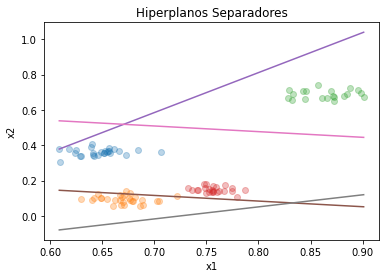

In [45]:
# Plotagem do hiperplano
plotDataset(Xtr, ytr)

for i in range(perceptron.w.shape[1]):
  plotHiperplano(Xtr, ytr, perceptron.w[1:,i], perceptron.w[0,i])

In [46]:
# Matriz com pesos
perceptron.w

array([[ 1.39720619,  0.75392486, -2.13938467, -0.83903148],
       [-3.16581555, -0.70794046,  0.93480156,  1.15881229],
       [ 1.40037706, -2.21790337,  2.91643068, -1.69994558]])

## Experimentos

### Dataset 1 (tipo binário)

In [62]:
from sklearn.datasets import load_breast_cancer
data = load_breast_cancer()
X = data['data']
y = data['target']

Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=.2)



**Hinge loss**

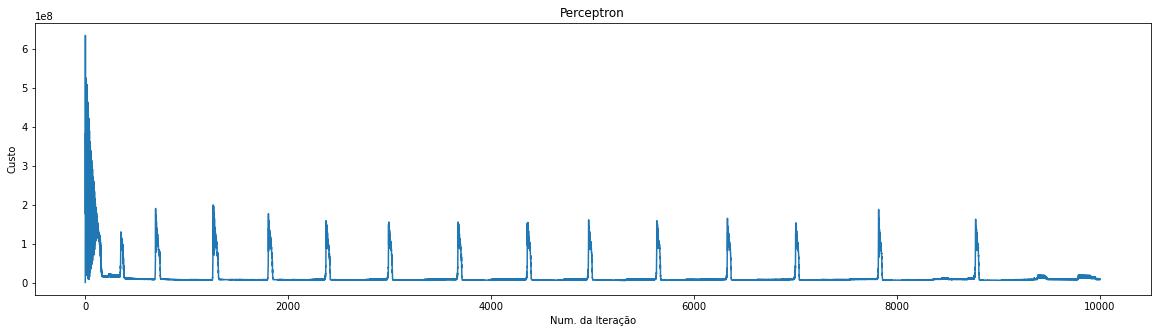

Train Acuracy:  0.9098901098901099
Test Acuracy:  0.9035087719298246


In [66]:
# Criacao do modelo
perceptron = Perceptron(DescidaGradiente(max_iter=10000, learning_rate=0.01,cost=HingeLoss()))
perceptron.fit(Xtr,ytr)

cost = perceptron.training_algorithm.cost_batch
plotCost(cost)

# Avaliacao do modelo para o conjunto de treino
ypred = perceptron.predict(Xtr,ytr)
print("\nTrain Acuracy: ", sum(ytr == ypred)/len(ytr))

# Avaliacao do modelo para o conjunto de teste
ypred = perceptron.predict(Xte,yte)
print("Test Acuracy: ", sum(yte== ypred)/len(yte))

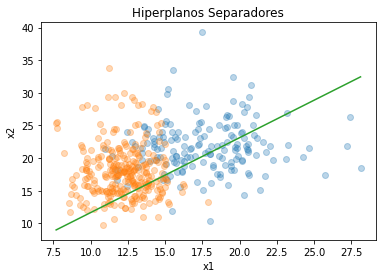

In [67]:
# Plotagem do hiperplano
plotDataset(Xtr, ytr)

for i in range(perceptron.w.shape[1]):
  plotHiperplano(Xtr, ytr, perceptron.w[1:,i], perceptron.w[0,i])

**Smoothed Surrogate**

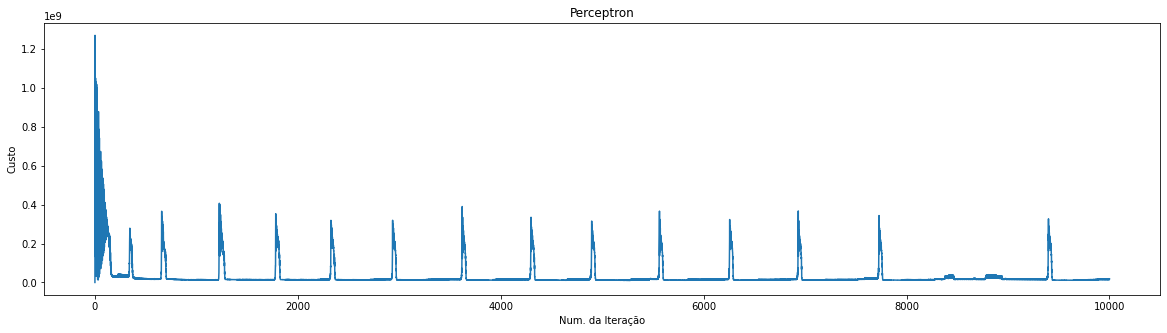

Train Acuracy:  0.8857142857142857
Test Acuracy:  0.9122807017543859


In [68]:
# Criacao do modelo
perceptron = Perceptron(DescidaGradiente(max_iter=10000, learning_rate=0.01,cost=SmoothedSurrogate()))
perceptron.fit(Xtr,ytr)

cost = perceptron.training_algorithm.cost_batch
plotCost(cost)

# Avaliacao do modelo para o conjunto de treino
ypred = perceptron.predict(Xtr,ytr)
print("\nTrain Acuracy: ", sum(ytr == ypred)/len(ytr))

# Avaliacao do modelo para o conjunto de teste
ypred = perceptron.predict(Xte,yte)
print("Test Acuracy: ", sum(yte== ypred)/len(yte))

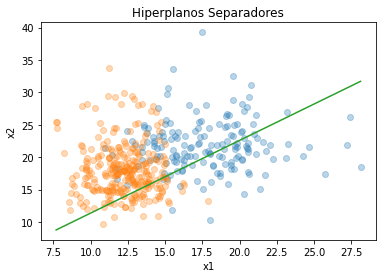

In [69]:
# Plotagem do hiperplano
plotDataset(Xtr, ytr)

for i in range(perceptron.w.shape[1]):
  plotHiperplano(Xtr, ytr, perceptron.w[1:,i], perceptron.w[0,i])

### Dataset 2 (tipo  multiclasse)

In [73]:
from sklearn.datasets import load_iris
data = load_iris()
X = data['data']
y = data['target']

Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=.2)

**Hinge loss**

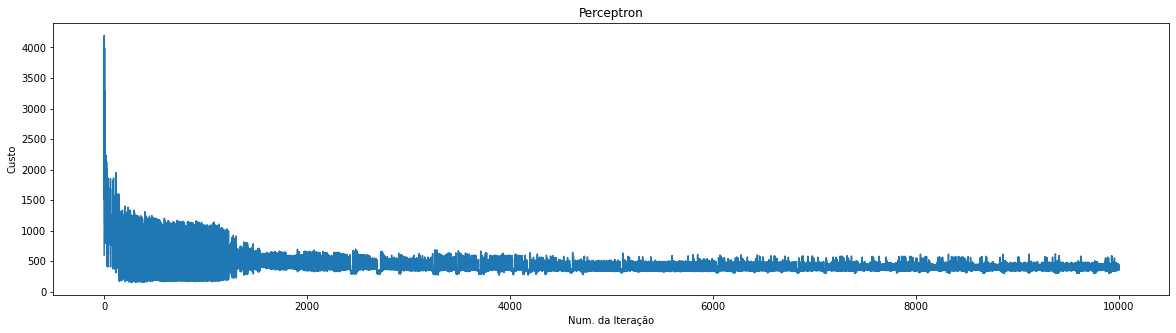


Train Acuracy:  0.875
Test Acuracy:  0.7333333333333333


In [74]:
# Criacao do modelo
perceptron = Perceptron(DescidaGradiente(max_iter=10000, learning_rate=0.01,cost=HingeLoss()))
perceptron.fit(Xtr,ytr)

cost = perceptron.training_algorithm.cost_batch
plotCost(cost)

# Avaliacao do modelo para o conjunto de treino
ypred = perceptron.predict(Xtr,ytr)
print("\nTrain Acuracy: ", sum(ytr == ypred)/len(ytr))

# Avaliacao do modelo para o conjunto de teste
ypred = perceptron.predict(Xte,yte)
print("Test Acuracy: ", sum(yte== ypred)/len(yte))

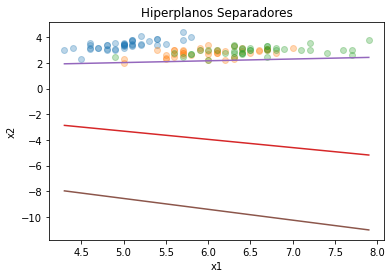

In [75]:
# Plotagem do hiperplano
plotDataset(Xtr, ytr)

for i in range(perceptron.w.shape[1]):
  plotHiperplano(Xtr, ytr, perceptron.w[1:,i], perceptron.w[0,i])

**LogLikehood**

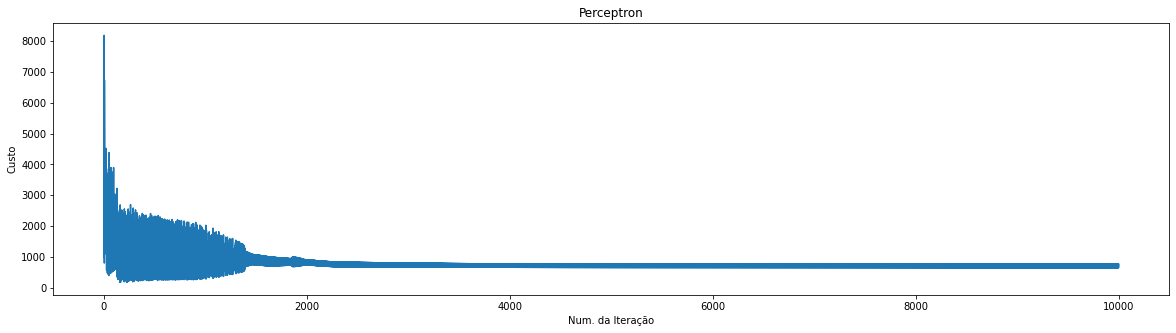


Train Acuracy:  0.85
Test Acuracy:  0.7333333333333333


In [78]:
# Criacao do modelo
perceptron = Perceptron(DescidaGradiente(max_iter=10000, learning_rate=0.01,cost=LogLikehood()))
perceptron.fit(Xtr,ytr)

cost = perceptron.training_algorithm.cost_batch
plotCost(cost)

# Avaliacao do modelo para o conjunto de treino
ypred = perceptron.predict(Xtr,ytr)
print("\nTrain Acuracy: ", sum(ytr == ypred)/len(ytr))

# Avaliacao do modelo para o conjunto de teste
ypred = perceptron.predict(Xte,yte)
print("Test Acuracy: ", sum(yte== ypred)/len(yte))

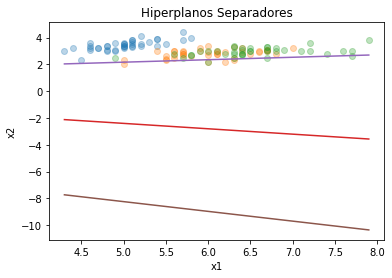

In [79]:
# Plotagem do hiperplano
plotDataset(Xtr, ytr)

for i in range(perceptron.w.shape[1]):
  plotHiperplano(Xtr, ytr, perceptron.w[1:,i], perceptron.w[0,i])